<a href="https://colab.research.google.com/github/Kambey-san/IMDA/blob/HW_lesson_03/KAA_IMDA_HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение в анализ данных в медицине
### Урок 3. Data Science: разработке и тестировании лекарств/ ДЗ

В онлайн-инструментах (и не только) используются данные о химических веществах в формате SMILES. Обычно он используется для описания структуры химических молекул. SMILES - это аббревиатура от Simplified Molecular Input Line Entry Specification.
Все основные данные о веществах можно найти в базе данных PubChem. PubChem в основном содержит небольшие молекулы, но также и более крупные молекулы, такие как нуклеотиды, углеводы, липиды, пептиды и химически модифицированные макромолекулы. Также есть информация о химических структурах, идентификаторах, химических и физических свойствах, биологической активности, патентах, данных о здоровье, безопасности, токсичности и многом другом.
Некоторые инструменты для предсказания мишеней:

● SwissTargetPrediction - позволяет оценить наиболее вероятные макромолекулярные мишени небольшой молекулы, предполагаемой как биологически активная. Предсказание основано на сочетании двухмерного и трехмерного сходства с библиотекой из 370 000 известных активных веществ для более чем 3000 белков трех разных видов.

● Super-PRED - веб-сервер прогнозирования соединений, основанный на модели машинного обучения с использованием логистической регрессии.

● Tools4miRs - представляет собой веб-мета-сервер прогнозирования целей, включающий определяемые пользователем методы прогнозирования целей при анализе предоставленных пользователями данных.
Попробуйте поработать с ними!



In [39]:
!pip install rdkit

In [40]:
%matplotlib inline

import os

from rdkit import rdBase

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from IPython.display import display

from rdkit.Chem import PandasTools
import pandas as pd
PandasTools.pd = pd

import numpy as np

np.random.seed(69)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#from bokeh import mpl
#from bokeh.plotting import output_notebook, show

print("RDKit Version: %s" % rdBase.rdkitVersion)

RDKit Version: 2023.09.5


In [41]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [42]:
link = 'https://drive.google.com/file/d/1xJPi74x4jQBiiL3v15gUdiefBDdY7ZqT/view?usp=drive_link'

id_test = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id_test})
downloaded.GetContentFile('validation_molecules_2019.smi')

Данные взяты из <a href='http://www.swisstargetprediction.ch/download.php'>SwissTargetPrediction</a>.

### Подготовка данных:

In [43]:
smiles_file = os.path.join(os.path.abspath(os.curdir) ,"/content/validation_molecules_2019.smi")

mols_dict = dict()
bad_mols = 0
bad_smiles = list()
dup_mols = 0
with open(smiles_file, "r") as fd:
    header = fd.readline()
    for line in fd.readlines():
        line = line.split()
        #print line
        # Add molecule information in a dictionary...
        # SMILES: (Mol_Id, Mol_Obj)
        smiles = line[0]
        mol_id = line[1]
        mol_obj = Chem.MolFromSmiles(smiles)
        # Skip bad molecules...
        if mol_obj is None:
            bad_mols += 1
            bad_smiles.append(smiles)
            continue
        if smiles in mols_dict:
            dup_mols += 1
            continue
        mols_dict[smiles] = (mol_id, mol_obj)
    # end for
# end with

print("Bad Mols: %s" % bad_mols)
print("Bad SMILES: %s" % bad_smiles)
print("Duplicate Mols: %s" % dup_mols)
print(len(mols_dict))

# Random selection of 30 molecules
# selected_smiles = np.random.choice(mols_dict.keys(), 30, replace=False)
selected_smiles = np.random.choice(len(mols_dict.keys()), 30, replace=False)

print(len(selected_smiles))
tmp_dict = dict()
# for smiles in selected_smiles:
#   tmp_dict[smiles] = mols_dict[smiles]

# # end for
# print(len(tmp_dict))

# mols_dict = tmp_dict.copy()

Bad Mols: 0
Bad SMILES: []
Duplicate Mols: 0
499
30


### Создаём датафрейм:

In [44]:
# Create a dataframe to store molecules
mols_df = pd.DataFrame(columns=("SMILES", "Mol_Id"))
for smiles in mols_dict:
    mol_id = mols_dict[smiles][0]
    mols_df = mols_df.append({"SMILES": smiles, "Mol_Id": mol_id}, ignore_index=True)

<ipython-input-44-74ab80dd1992>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mols_df = mols_df.append({"SMILES": smiles, "Mol_Id": mol_id}, ignore_index=True)
<ipython-input-44-74ab80dd1992>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mols_df = mols_df.append({"SMILES": smiles, "Mol_Id": mol_id}, ignore_index=True)
<ipython-input-44-74ab80dd1992>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mols_df = mols_df.append({"SMILES": smiles, "Mol_Id": mol_id}, ignore_index=True)
<ipython-input-44-74ab80dd1992>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mols_df = mols_df.append({"SMILES": smiles, "Mol_Id": mol_id}, ignore_inde

### Генерируем молекулярные объекты:

,SMILES,Mol_Id,Molecule
0,COc1c(OCCCN2CCOCC2)ccc2c1nc(NC(=O)c1cnc(nc1)N)...,CHEMBL3218576,
1,COc1cc(OC)c(cc1[C@H]1[C@H](c2ccccc2)C(=O)N1c1c...,CHEMBL3883491,
2,COc1ccc(cc1OC)[C@@H]1N(c2ccc(cc2)S(=O)(=O)N)C(...,CHEMBL3884217,
3,COc1ccc(cc1)[C@@H]1C(=O)N([C@H]1c1ccc(c(c1)OC)...,CHEMBL3885230,
4,Fc1cccc(c1)C(=O)N(C1(CCC(CC1)(N(C)C)c1ccccc1)c...,CHEMBL3889835,
...,...,...,...
494,FC(Oc1ccc(cc1c1nn(cc1N=C(c1cnn2c1nccc2)O)CC(=O...,CHEMBL3984720,
495,CCNC1CCN(CC1)C(=O)Cn1cc(c(n1)c1cc(Cl)ccc1OC(F)...,CHEMBL3984741,
496,N#Cc1ccc(nc1)N([C@@H]1CCN(C1)c1ncnc2c1cc[nH]2)...,CHEMBL3984764,
497,OC[C@H](c1ccccc1)N=C(c1ccc(nc1)N([C@@H]1CCN(C1...,CHEMBL3984793,

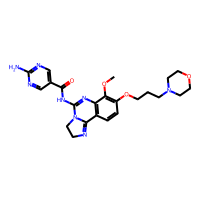
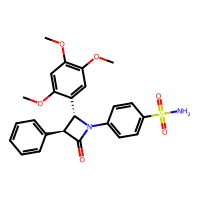
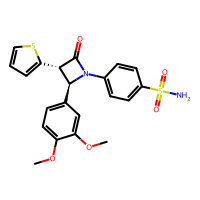
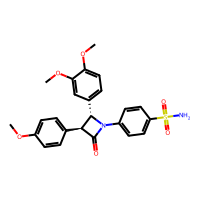
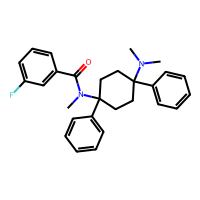
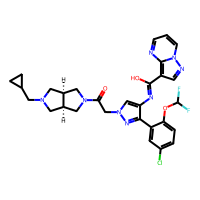
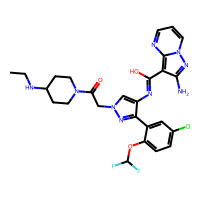
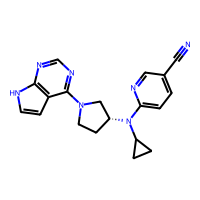
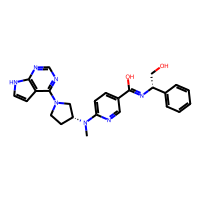
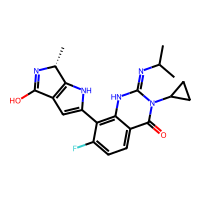

In [45]:
# Generate molecules objects
PandasTools.AddMoleculeColumnToFrame(mols_df, 'SMILES', 'Molecule', includeFingerprints=True)
display(mols_df)

### Берём первую попавшуюся с ID0 и забрасываем в PubChem,
далее cкачиваем данные для анализа в формате .csv

In [50]:
link = 'https://drive.google.com/file/d/1VJSxPPU-pOxxr3RmcKEvPkP8cSK_FnMw/view?usp=drive_link'

id_test = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id_test})
downloaded.GetContentFile('PubChem_compound_smiles_0ID.csv')

In [51]:
df = pd.read_csv('PubChem_compound_smiles_0ID.csv')
pd.set_option('display.max_rows', None)
df

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,135565596,Copanlisib,Copanlisib|1032568-63-0|BAY 80-6946|BAY-80-694...,480.5,C23H28N8O4,140.0,974.0,0.3,35,2,...,823,2D+3D,NaN,Biological Test Results|Classification|Drug an...,11,1|3|5|7|9|13|15|19|21|23|25|29|31|33|35|37|39|...,20190115,001Chemical|4C Pharma Scientific Inc|A2B Chem|...,Chemical Vendors|Curation Efforts|Governmental...,C274 - Antineoplastic Agent > C163758 - Target...


**Описание:**

Копанлисиб представляет собой имидазохиназолин, который представляет собой 2,3-дигидроимидазо[1,2-с]хиназолин, замещенный (2-аминопиримидин-5-карбонил)амино, метокси и 3-(морфолин-4-ил)пропокси группами в положениях 5. 7 и 8 соответственно. Это внутривенный ингибитор PI3K пан-класса I, используемый для лечения рецидивирующей фолликулярной лимфомы у пациентов, получивших как минимум 2 предшествующих системных лечения. Он играет роль ингибитора EC 2.7.1.137 (фосфатидилинозитол-3-киназы), противоопухолевого агента и индуктора апоптоза. Он входит в состав морфолинов, ароматического эфира, диэфира, третичного аминосоединения, вторичного карбоксамида, пиримидинкарбоксамида, аминопиримидина и имидазохиназолина.

**По классификации FDA:**

Копанлисиб — это внутривенно вводимый ингибитор фосфатидилинозитол-3-киназы, который используется для лечения рецидивирующей и рефрактерной фолликулярной лимфомы

**Токсичность:**

Копанлисиб представляет собой ингибитор фосфоинозитид-3-киназы (PI3K) с потенциальной противоопухолевой активностью. Копанлисиб ингибирует активацию сигнального пути PI3K, что может привести к ингибированию роста и выживания опухолевых клеток в восприимчивых популяциях опухолевых клеток. Активация сигнального пути PI3K часто связана с онкогенезом, а нарушение регуляции передачи сигналов PI3K может способствовать устойчивости опухоли к различным противоопухолевым агентам.


**Выводы:** *на основе данных, полученных с ресурса SwissTargetPrediction, удалось "сгенерировать" молекулярные объекты, в дальнейшем, при помощи ресурса PubChem, описать их формулу, механизм действия, мишени, токсические свойства*